In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats

In [2]:
%store -r data_frame_2
df = data_frame_2

In [3]:
def mergesort(l):
    
    length = len(l)
    if length <= 1:
        return l
    
    else:
        first = mergesort(l[:length//2])
        second = mergesort(l[length//2:])
        i = j = 0
        s = [] #new sorted array
        
        # Merge by comparing the smallest (unused) elements in each list
        while i < len(first) and j < len(second):
            if first[i] <= second[j]:
                s.append(first[i])
                i += 1
            else:
                s.append(second[j])
                j += 1
        
        # Add in all remaining elements from 'first'
        while i < len(first):
            s.append(first[i])
            i += 1
        
        # Add in all remaining elements from 'second'
        while j < len(second):
            s.append(second[j])
            j += 1

        return s

In [4]:
'''
Function that checks whether or not a list exists in a list of lists
'''
def list_present(toplist, sublist):
    for i in toplist:
        if sublist == i:
            return True
    return False

In [5]:
comparisons = []
for x in list(df['comparison_type']):
    if type(x) == list:
        if not list_present(comparisons, x):
            comparisons.append(x)

In [6]:
distances = []
for comp in comparisons:
    distances.append(comp[0])
    distances.append(comp[1])
distances = list(set(distances))
distances = mergesort(distances)
distances

[4, 6, 8, 10, 14, 18, 22, 28, 34, 40]

In [7]:
'''
Recreating the accuracy graph from the JOI vs JOR paper by Mark Howard

Takes in a specified pandas dataframe with the correct fields from
the JOR v1.0 or v1.1 experiment and outputs a correctness graph in the
manner of the JOI vs JOR paper.
'''
def recreate_accuracy_graph(df, comparisons, distances):

    '''
    '''
    def average_for_comp(df, comp):
        ordered = df[df['left_comp_type'] == comp[0]]
        ordered = ordered[ordered['right_comp_type'] == comp[1]]
        inverse = df[df['left_comp_type'] == comp[1]]
        inverse = inverse[inverse['right_comp_type'] == comp[0]]
        temp = pd.concat([ordered, inverse])
        corr = temp[temp['correct_side'] == temp['chosen_side']]
        proportion = (len(corr)) / len(temp)
        return proportion
    
    
    '''
    NOTE: this is standard error of the mean over subjects
    '''
    def ste_for_comp(df, comp):
        
        means = []
        for i in df['uniqueid'].unique():
            temp_df = df[df['uniqueid'] == i]
            means.append(average_for_comp(temp_df, comp))
        
        return stats.sem(means)
    

    '''
    '''
    def graph_for_distance(more_recent_item, comparisons, distances, df):
        y = []
        x = []
        yerr = []
        for i in range(len(distances)):
            if i < more_recent_item:
                x.append(distances[i])
                y.append(average_for_comp(df, [distances[more_recent_item], distances[i]]))
                yerr.append(ste_for_comp(df, [distances[more_recent_item], distances[i]]))

        x = np.array(x)
        y = np.array(y)
        yerr = np.array(yerr)
        
        # graph the line:
        color = 'black'
        marker = 'o'

        #colors = ['lightgray', 'silver', 'darkgrey', 'gray', 'dimgrey', 'black']
        #color = colors[more_recent_item]
        #markers = ['o', 'v', 's', 'P', 'd', 'X' ]
        #marker = markers[index]

        # Graph line
        #ax.plot(x, y, clip_on = False, color = color, marker = marker, label=distances[more_recent_item])
        #ax.fill_between(x, y-yerr, y+yerr, alpha=0.7, edgecolor=color, facecolor=color)
        ax.errorbar(x, y, yerr=yerr, clip_on = False, marker = marker, label=distances[more_recent_item])

    fig, ax = plt.subplots()
    #plt.ylim(0, 1)
    plt.title('Accuracy In Cross Category Judgments')
    plt.ylabel('Accuracy')
    plt.xlabel('Lag to the less recent probe')
    ax.yaxis.set_ticks_position('both')

    for i in range(len(distances)):
        if not distances[i] == 'many':
            graph_for_distance(i, comparisons, distances, df)

    lgd = plt.legend(title = 'Lag to the more\n  recent probe', fancybox=True, bbox_to_anchor=(1.32, 1))
    plt.savefig('joir_accuracy_mimic.pdf', format='pdf', dpi=1200, bbox_extra_artists=[lgd], bbox_inches='tight')
    plt.show()

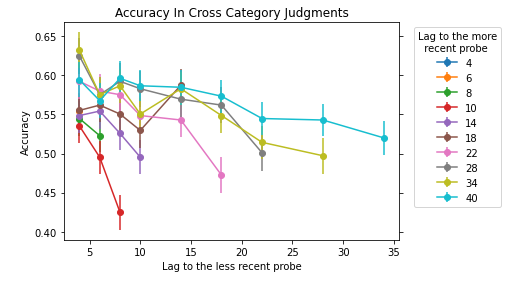

In [8]:
recreate_accuracy_graph(df, comparisons, distances)